<h1><center><font size="6">Santander Customer Transaction Prediction</font></center></h1>
<h1><center><font size="5">Can you identify who will make a transaction?</font></center></h1>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg/640px-Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg" width="500"></img>

<br>
<b>
    
Our data science team is continually challenging our machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.

The data is anonimyzed, each row containing 200 numerical values identified just with a number.</b>
     


<a id=1><pre><b>Load Packages</b></pre></a>

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numba import jit
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import warnings
warnings.filterwarnings('ignore')
# Any results you write to the current directory are saved as output.

<a id=1><pre><b>Import the Data</b></pre></a>

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [5]:
test_df.shape, train_df.shape

((200000, 201), (200000, 202))

In [6]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [7]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


**Missing data**

In [8]:
train_df.isnull().values.any()

False

In [9]:
test_df.isnull().values.any()

False

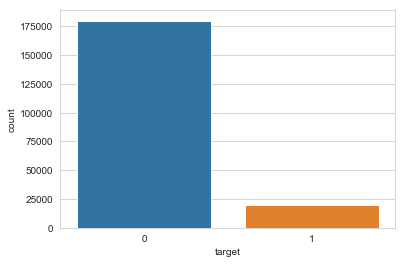

In [10]:
sns.set_style('whitegrid')
sns.countplot(train_df['target'])
sns.set_style('whitegrid')

In [12]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

<a id=1><pre><b>Classification augment</b></pre></a>

In [13]:
@jit
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

# Run Model

<a id=1><pre><b>Parameters</b></pre></a>

In [14]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

In [15]:
#kfold = 15
#folds = StratifiedKFold(n_splits=kfold, shuffle=False, random_state=44000)
num_folds = 11
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]

folds = KFold(n_splits=num_folds, random_state=44000)
oof = np.zeros(len(train_df))
getVal = np.zeros(len(train_df))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

<a id=1><pre><b>Run model</b></pre></a>

In [16]:
print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    
    X_train, y_train = train_df.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train_df.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


Light GBM Model
Fold idx:1
Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[1512]	training's auc: 0.926547	valid_1's auc: 0.90045
Fold idx:2
Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[1055]	training's auc: 0.92104	valid_1's auc: 0.895397
Fold idx:3
Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[1382]	training's auc: 0.926116	valid_1's auc: 0.889785
Fold idx:4
Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[1506]	training's auc: 0.927534	valid_1's auc: 0.9017
Fold idx:5
Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[1542]	training's auc: 0.927473	valid_1's auc: 0.895746
Fold idx:6
Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[1159]	training's auc: 0.921841	valid_1's auc: 0

In [17]:
print("\n >> CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


 >> CV score: 0.89858 


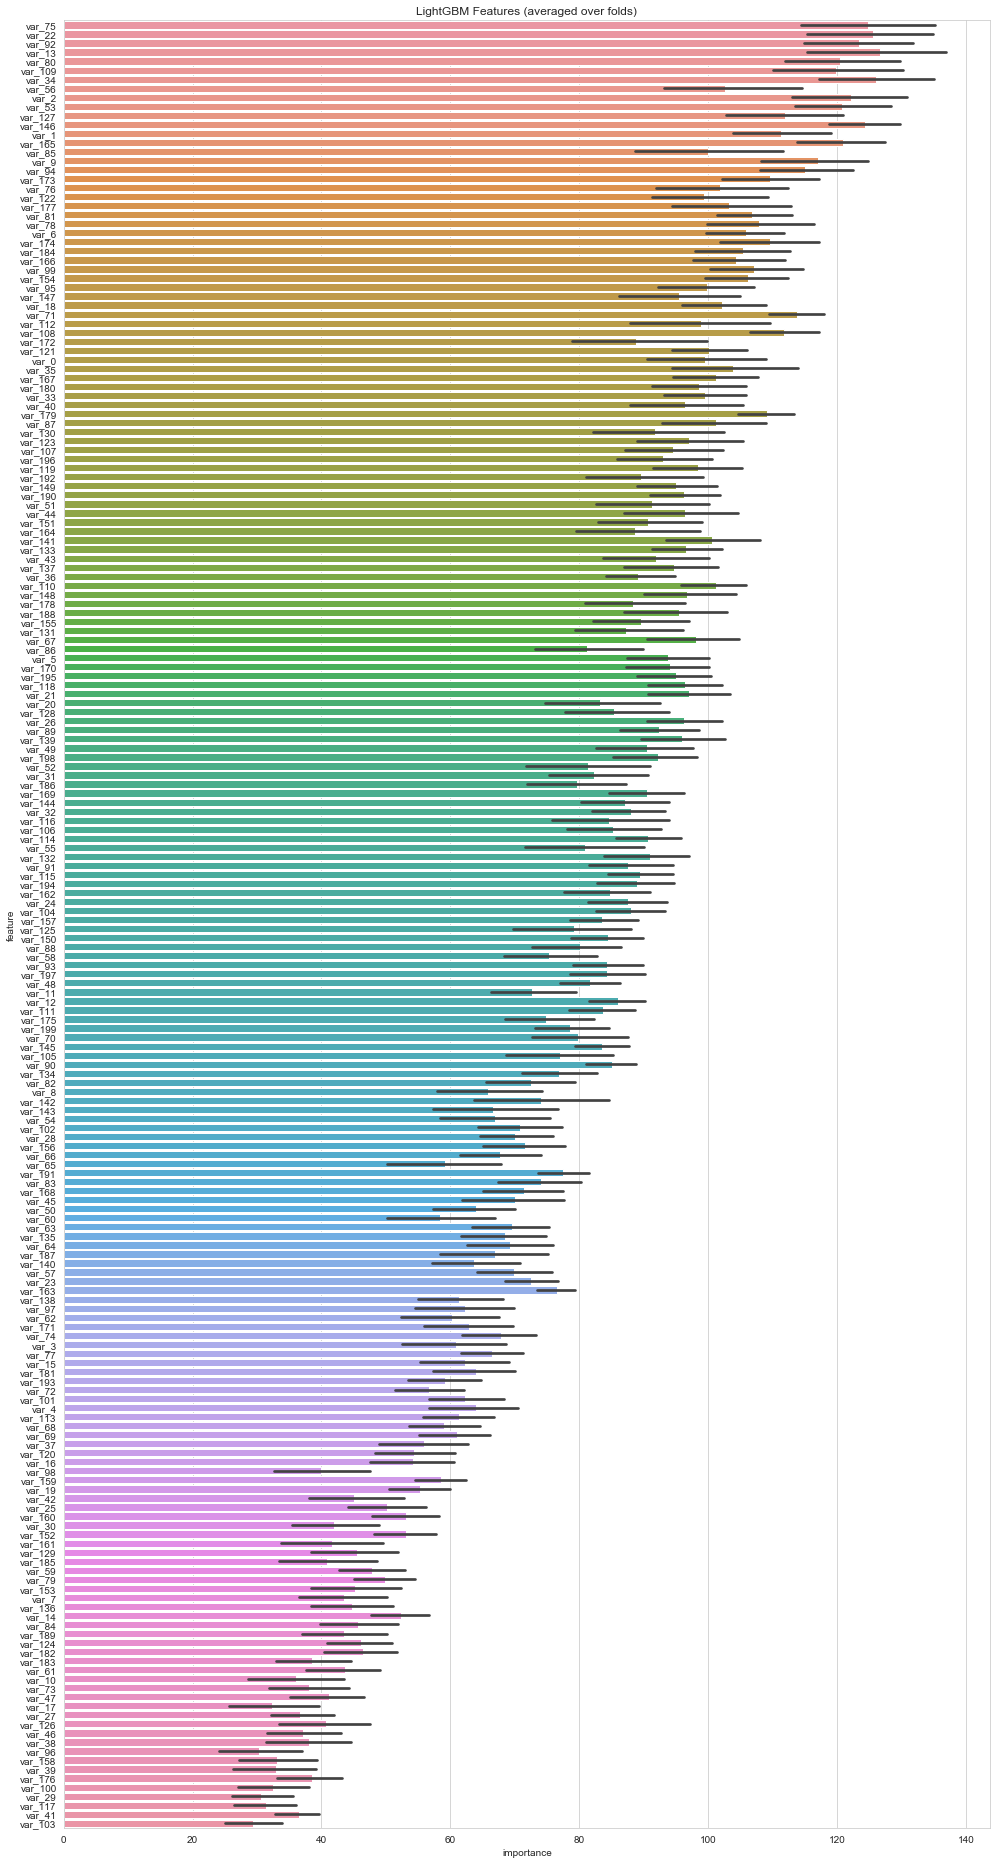

In [18]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

# Submission

In [19]:
submission = pd.DataFrame({"ID_code": test_df.ID_code.values})
submission["target"] = predictions
submission.to_csv("submission.csv", index=False)

In [20]:
submission.head()

,ID_code,target
0,test_0,0.139231
1,test_1,0.272098
2,test_2,0.209434
3,test_3,0.320515
4,test_4,0.056452


# Blanding

In [25]:
s1 = pd.read_csv('submission._lgb.csv')['target']#[1]
s2 = pd.read_csv('submission_best_cat.csv')['target']#[2]

submission = pd.read_csv('sample_submission.csv')

In [26]:
# blender
submission['target'] = 1/2 * (s1 + s2)

filename="blended_submission_1.csv"
submission.to_csv(filename, index=False)